<a href="https://colab.research.google.com/github/vanessarifianto/datathon-2025-lifeline-team76/blob/main/datathon76.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install pandas numpy scikit-learn imbalanced-learn matplotlib seaborn xlrd openpyxl

Using target: NSP
Class distribution:
 NSP
0    1655
1     295
2     176
Name: count, dtype: int64
LogReg | Macro-F1=0.787 | BalAcc=0.850
RF | Macro-F1=0.899 | BalAcc=0.906
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best RF params: {'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best Macro-F1 (CV): 0.9040694647924262

Hold-out evaluation (best RF):
Balanced Acc: 0.8990995458832911
Macro F1    : 0.8841805188896049
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       332
           1       0.77      0.80      0.78        59
           2       0.87      0.94      0.90        35

    accuracy                           0.93       426
   macro avg       0.87      0.90      0.88       426
weighted avg       0.94      0.93      0.93       426



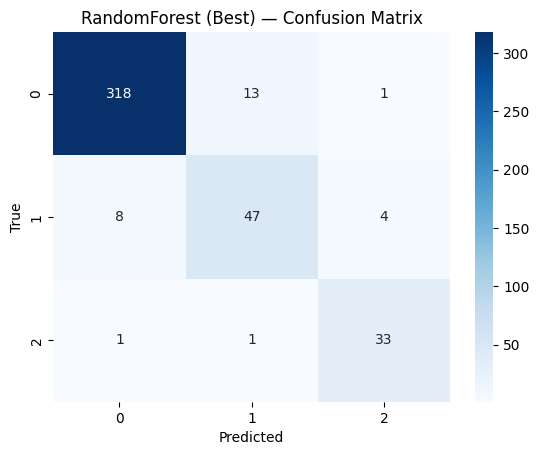


Top 10 features:
 ASTV        0.159256
ALTV        0.147033
Mean        0.116989
AC          0.095068
Median      0.082139
DP          0.066257
Mode        0.052539
LB          0.048446
Variance    0.041511
Width       0.039366
dtype: float64


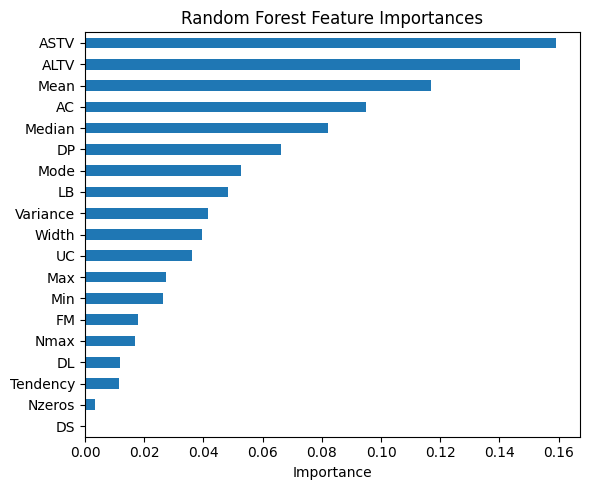

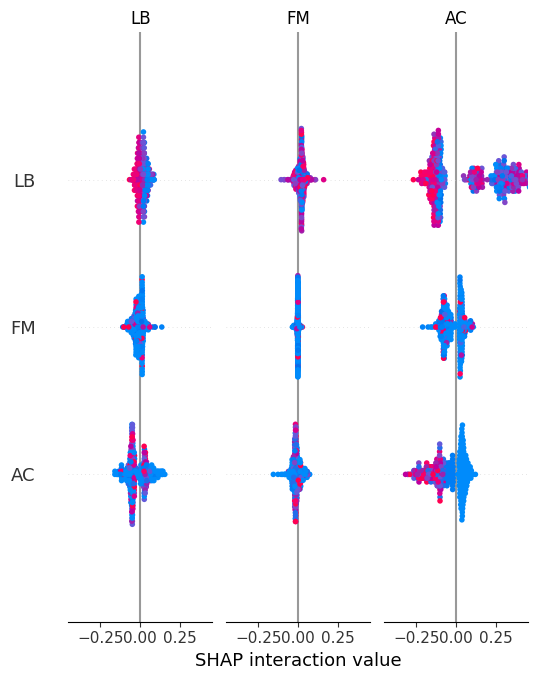

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    balanced_accuracy_score, f1_score, classification_report,
    confusion_matrix, precision_recall_fscore_support
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

#Load dataset

URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00193/CTG.xls"

def load_ctg(url=URL):
    xl = pd.ExcelFile(url)
    target_candidates = ["NSP", "CLASS", "CLASS\n"]
    for sheet in xl.sheet_names:
        df = pd.read_excel(url, sheet_name=sheet)
        df.columns = df.columns.astype(str).str.strip()
        for t in target_candidates:
            if t in df.columns:
                return df, t
    raise ValueError(f"Target not found in sheets: {xl.sheet_names}")

df, target_col = load_ctg()
print("Using target:", target_col)

#Select features + target

features = ['LB','AC','FM','UC','ASTV','mSTV','ALTV','mLTV',
            'DL','DS','DP','Width','Min','Max','Nmax','Nzeros',
            'Mode','Mean','Median','Variance','Tendency']
features = [c for c in features if c in df.columns]

data = df[features + [target_col]].dropna().copy()
y = data[target_col].astype(int)
if y.min() == 1:   # map 1,2,3 → 0,1,2
    y = y - 1
X = data[features].copy()

print("Class distribution:\n", y.value_counts())

#Train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


#Define pipeline maker

def make_pipe(model):
    return Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("clf", model),
    ])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Baseline models

models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "RF": RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42),
}

for name, mdl in models.items():
    pipe = make_pipe(mdl)
    scores = cross_validate(
        pipe, X, y, cv=cv,
        scoring={"macro_f1": "f1_macro", "bal_acc": "balanced_accuracy"},
        n_jobs=-1
    )
    print(f"{name} | Macro-F1={scores['test_macro_f1'].mean():.3f} "
          f"| BalAcc={scores['test_bal_acc'].mean():.3f}")

#GridSearch for RF

rf_pipe = make_pipe(RandomForestClassifier(class_weight="balanced", random_state=42))
param_grid = {
    "clf__n_estimators": [200, 300, 500],
    "clf__max_depth": [None, 6, 10],
    "clf__min_samples_split": [2, 5],
}
grid = GridSearchCV(rf_pipe, param_grid, cv=cv, scoring="f1_macro", n_jobs=-1, verbose=1)
grid.fit(X, y)

print("\nBest RF params:", grid.best_params_)
print("Best Macro-F1 (CV):", grid.best_score_)

best_model = grid.best_estimator_

#Hold-out evaluation

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("\nHold-out evaluation (best RF):")
print("Balanced Acc:", balanced_accuracy_score(y_test, y_pred))
print("Macro F1    :", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

#Confusion matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("RandomForest (Best) — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#Feature importances

rf_fitted = best_model.named_steps["clf"]
importances = pd.Series(rf_fitted.feature_importances_, index=features).sort_values(ascending=False)
print("\nTop 10 features:\n", importances.head(10))

importances.sort_values().plot(kind="barh", figsize=(6,5))
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

#SHAP explainability

import shap
explainer = shap.TreeExplainer(rf_fitted)
X_std = best_model.named_steps["scaler"].transform(X_test)
shap_values = explainer.shap_values(X_std)
shap.summary_plot(shap_values, X_std, feature_names=features)


In [ ]:
# imports + folders + reproducibility
import os, json, random, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from datetime import datetime

def ensure_dirs():
    Path("outputs").mkdir(parents=True, exist_ok=True)
    Path("outputs/pr_curves").mkdir(parents=True, exist_ok=True)
    Path("models").mkdir(parents=True, exist_ok=True)

def set_seed(seed=42):
    np.random.seed(seed); random.seed(seed)

def log_run(meta, path="outputs/run_meta.jsonl"):
    ensure_dirs()
    with open(path, "a") as f:
        f.write(json.dumps(meta) + "\n")

ensure_dirs(); set_seed(42)
log_run({
    "when": datetime.now().isoformat(timespec="seconds"),
    "cv_folds": getattr(cv, "n_splits", None),
    "best_params": getattr(grid, "best_params_", None)
})
print("Setup complete.")


Setup complete.


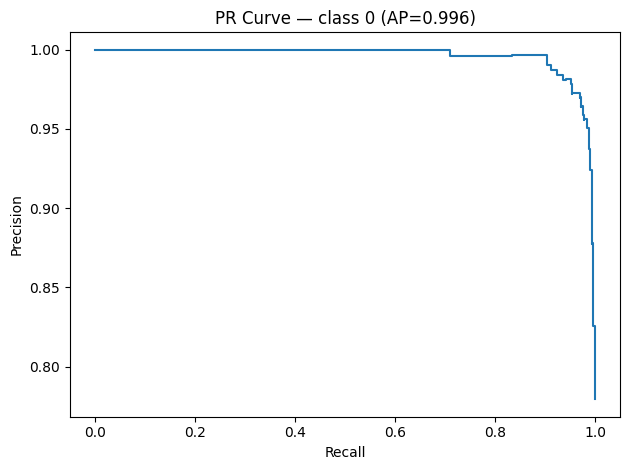

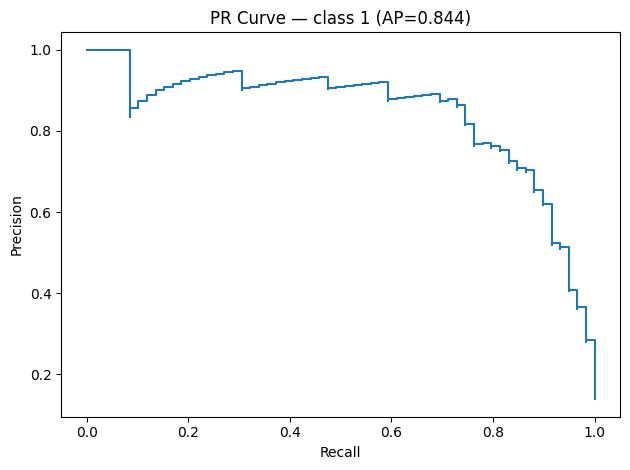

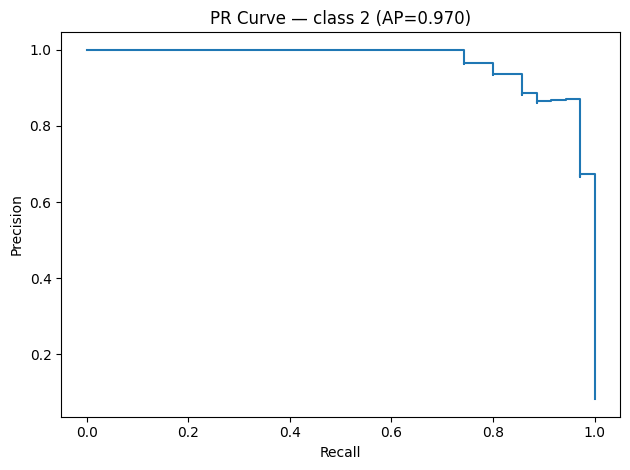

Macro AUPRC: 0.937


In [ ]:
# PR curves and macro AUPRC (uses best_model.predict_proba on X_test)
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

proba = best_model.predict_proba(X_test)
classes = np.unique(y_test)
auprc = []

for i, c in enumerate(classes):
    y_true = (y_test == c).astype(int)
    y_score = proba[:, i]
    ap = average_precision_score(y_true, y_score)
    auprc.append(ap)
    p, r, _ = precision_recall_curve(y_true, y_score)
    plt.figure()
    plt.step(r, p, where="post")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"PR Curve — class {c} (AP={ap:.3f})")
    plt.tight_layout()
    plt.savefig(f"outputs/pr_curves/class_{c}.png", dpi=180)
    plt.show()

macro_auprc = float(np.mean(auprc))
print(f"Macro AUPRC: {macro_auprc:.3f}")
pd.Series(auprc, index=[f"class_{int(c)}" for c in classes]).to_csv("outputs/pr_curves/auprc_per_class.csv")


In [ ]:
#tune an operating point by shaping calibrated probabilities
import numpy as np
use_model = calibrated_model if 'calibrated_model' in globals() else best_model
proba = use_model.predict_proba(X_test)

thresholds = np.linspace(0.2, 0.8, 25)
best_t, best_f1 = 0.5, -1.0

from sklearn.metrics import f1_score
for t in thresholds:
    adj = np.where(proba >= t, proba, proba * 0.5)  #simple shaping, keeps multiclass
    y_pred_t = adj.argmax(axis=1)
    f1 = f1_score(y_test, y_pred_t, average="macro")
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"Best Macro-F1 after threshold shaping: {best_f1:.3f} at t={best_t:.2f}")


Best Macro-F1 after threshold shaping: 0.884 at t=0.20


Saved: outputs/permutation_importance.csv


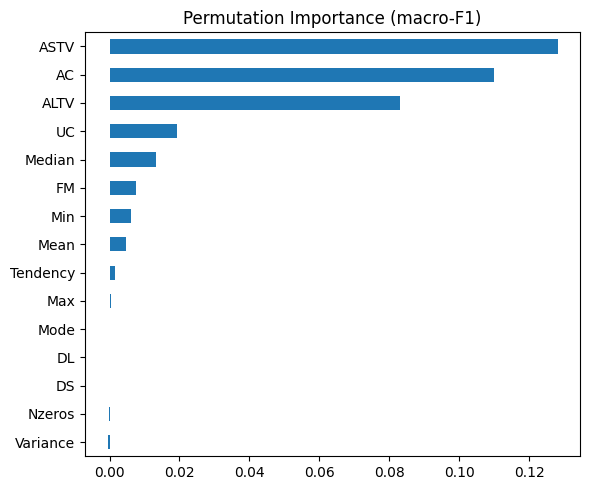

In [ ]:
# Complement RF's impurity importances with permutation importance on hold-out
from sklearn.inspection import permutation_importance

r = permutation_importance(best_model, X_test, y_test,
                           scoring="f1_macro", n_repeats=10, random_state=42, n_jobs=-1)
pi = pd.Series(r.importances_mean, index=features).sort_values(ascending=False)
pi.to_csv("outputs/permutation_importance.csv")
print("Saved: outputs/permutation_importance.csv")
plt.figure(figsize=(6,5))
pi.head(15).sort_values().plot(kind="barh")
plt.title("Permutation Importance (macro-F1)")
plt.tight_layout()
plt.show()


In [ ]:
# Save model and add a quick CSV inference function
import joblib, numpy as np
from pathlib import Path

joblib.dump(best_model, "models/rf_smote_pipeline.joblib")
print("Saved model → models/rf_smote_pipeline.joblib")

def predict_csv(input_csv, output_csv="outputs/predictions.csv", model_path="models/rf_smote_pipeline.joblib"):
    Path("outputs").mkdir(parents=True, exist_ok=True)
    mdl = joblib.load(model_path)
    df_new = pd.read_csv(input_csv)
    use_cols = [c for c in features if c in df_new.columns]
    preds = mdl.predict(df_new[use_cols])
    out = df_new.copy(); out["prediction"] = preds
    out.to_csv(output_csv, index=False)
    print(f"Predictions → {output_csv}")

# predict_csv("data/new_cases.csv")


Saved model → models/rf_smote_pipeline.joblib


In [ ]:
# visualization suite
# hurray :D

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import cross_validate
import shap, time

plt.style.use('dark_background')

# -------------------------------------------------------------
# 1. problem framing & data handling
# -------------------------------------------------------------

# visualize class distribution before vs after smote
# shows data imbalance and how the pipeline fixes it
train_idx, test_idx = next(cv.split(X, y))
X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]

sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(StandardScaler().fit_transform(X_tr), y_tr)

orig = pd.Series(Counter(y_tr), name="original").sort_index()
smote = pd.Series(Counter(y_sm), name="after smote").sort_index()
pd.concat([orig, smote], axis=1).plot(kind="bar", figsize=(6,4))
plt.title("class distribution: original vs after smote (train fold)")
plt.xlabel("class"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# -------------------------------------------------------------
# 2. metric choice & imbalance management
# -------------------------------------------------------------

# visualize per-class average precision (auprc)
# supports metric fairness explanation for imbalanced data
pd.Series(auprc, index=[f"class_{int(c)}" for c in classes]).plot(kind="bar", color="#ffcc00")
plt.title(f"average precision (auprc) per class | macro={macro_auprc:.3f}")
plt.ylabel("average precision"); plt.ylim(0,1)
plt.tight_layout(); plt.show()

# visualize threshold tuning curve
# shows how macro-f1 varies with decision threshold
scores = []
for t in thresholds:
    adj = np.where(proba >= t, proba, proba * 0.5)
    y_pred_t = adj.argmax(axis=1)
    scores.append(f1_score(y_test, y_pred_t, average="macro"))
plt.plot(thresholds, scores, marker="o", color="#66ccff")
plt.axvline(best_t, ls="--", color="#ffcc00")
plt.title("macro-f1 vs threshold (tuning clinical sensitivity)")
plt.xlabel("threshold"); plt.ylabel("macro-f1")
plt.tight_layout(); plt.show()

# -------------------------------------------------------------
# 3. model performance & optimization
# -------------------------------------------------------------

# visualize cross-validation results by model
# compares logistic regression vs random forest on cv metrics
model_names, f1_means, bal_means = [], [], []
for name, mdl in models.items():
    pipe = make_pipe(mdl)
    scores = cross_validate(
        pipe, X, y, cv=cv,
        scoring={"macro_f1": "f1_macro", "bal_acc": "balanced_accuracy"},
        n_jobs=-1
    )
    model_names.append(name)
    f1_means.append(scores['test_macro_f1'].mean())
    bal_means.append(scores['test_bal_acc'].mean())

x = np.arange(len(model_names)); width = 0.35
plt.bar(x - width/2, f1_means, width, label='macro-f1', color='#ffcc00')
plt.bar(x + width/2, bal_means, width, label='balanced acc', color='#66ccff')
plt.xticks(x, model_names)
plt.title("cross-validation performance by model")
plt.ylabel("score"); plt.ylim(0.7, 1.0)
plt.legend(); plt.tight_layout(); plt.show()

# visualize grid search results
# shows how macro-f1 changes across rf hyperparameters
cvres = pd.DataFrame(grid.cv_results_)
cvres['max_depth'] = cvres.param_clf__max_depth
cvres['n_estimators'] = cvres.param_clf__n_estimators
pivot = cvres.pivot_table(values='mean_test_score', index='max_depth', columns='n_estimators')
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("grid search optimization — macro-f1 by hyperparameter")
plt.xlabel("n_estimators"); plt.ylabel("max_depth")
plt.tight_layout(); plt.show()

# visualize confusion matrix (hold-out)
# shows final class-level performance of the best model
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("random forest (best) — confusion matrix")
plt.xlabel("predicted"); plt.ylabel("true")
plt.tight_layout(); plt.show()

# -------------------------------------------------------------
# 4. explainability & clinical interpretability
# -------------------------------------------------------------

# visualize feature importance comparison
# contrasts random forest impurity vs permutation importance
imp_tree = pd.Series(rf_fitted.feature_importances_, index=features)
imp_perm = pi
top = pd.concat({"tree": imp_tree, "permutation": imp_perm}, axis=1).nlargest(12, "permutation")
top.plot(kind="bar", figsize=(7,4))
plt.title("feature importance — tree vs permutation (top 12)")
plt.ylabel("importance"); plt.tight_layout(); plt.show()

# visualize shap summary plot
# shows feature-level contribution for each observation
explainer = shap.TreeExplainer(rf_fitted)
X_std = best_model.named_steps["scaler"].transform(X_test)
shap_values = explainer.shap_values(X_std)
shap.summary_plot(shap_values, X_std, feature_names=features)

# -------------------------------------------------------------
# 5. engineering, latency & deployability
# -------------------------------------------------------------

# visualize inference latency by batch size
# demonstrates that prediction remains fast and scalable
batches = [10, 50, 100, 500, 1000]
n_test = len(X_test)
batches = [b for b in batches if b <= n_test] or [n_test]  # safe guard

times = []
for b in batches:
    Xb = X_test.sample(b, random_state=42, replace=False)
    t0 = time.time()
    _ = best_model.predict(Xb)
    times.append(time.time() - t0)

plt.plot(batches, times, marker="o", color="#ffcc00")
plt.xscale("log")
plt.xlabel("batch size (log)")
plt.ylabel("seconds")
plt.title("inference latency by batch size")
plt.tight_layout(); plt.show()

